In [41]:
from pathlib import Path
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import matplotlib.gridspec as gridspec

from applefy.detections.contrast import Contrast
from applefy.utils.positions import center_subpixel
from applefy.utils.file_handling import load_adi_data
from applefy.utils import flux_ratio2mag, mag2flux_ratio
from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, gaussian_sigma_2_fpf, \
    fpf_2_gaussian_sigma
from applefy.utils.file_handling import save_as_fits

from s4hci.detection_limits.applefy_wrapper import PCADataReductionGPU

from s4hci.utils.setups import contrast_grid_setup_1

# Load the data

In [2]:
dataset_name = "HD22049_303_199_C-0065_C_"

In [3]:
dataset_file = Path("/fast/mbonse/s4/30_data/" + dataset_name + ".hdf5")
experiment_root_dir = Path("/fast/mbonse/s4/70_results/10_contrast_grids/" + dataset_name)

In [4]:
# we need the psf template for contrast calculation
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

dit_psf_template = 0.0042560
dit_science = 0.08
fwhm = 3.6
pixel_scale=0.02718

In [5]:
# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

# Create Contrast instance

In [15]:
contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    scaling_factor=1., # A factor to account e.g. for ND filters
    checkpoint_dir=experiment_root_dir)

In [16]:
# get fake planet setup
flux_ratios, separations, num_fake_planets = contrast_grid_setup_1(fwhm)

In [17]:
tmp_config_dir = deepcopy(contrast_instance.config_dir)
contrast_instance.config_dir = None
contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)
contrast_instance.config_dir = tmp_config_dir

# Restore results

## 2.) PCA

In [18]:
pca_numbers = np.concatenate(
        [np.arange(0, 20, 2)[1:],
         np.arange(20, 50, 5),
         np.arange(50, 100, 10),
         np.arange(100, 200, 20),
         np.arange(200, 550, 50)])

pca_model = PCADataReductionGPU(
    approx_svd=8000,
    pca_numbers=pca_numbers,
    device=0,
    work_dir=None,
    special_name="pca_stacked_05",
    verbose=True)

In [19]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=pca_model,
    num_parallel=1)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:18<00:00, 51.52it/s]

[DONE]


# Compute the contrast grid

In [20]:
# Use apertures pixel values
photometry_mode_planet = AperturePhotometryMode(
    "AS", # or "ASS"
    psf_fwhm_radius=fwhm/2,
    search_area=0.5)

photometry_mode_noise = AperturePhotometryMode(
    "AS",
    psf_fwhm_radius=fwhm/2)

In [21]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

In [22]:
statistical_test = TTest()

In [23]:
contrast_curves_grid, contrast_grids = contrast_instance.compute_contrast_grids(
    statistical_test=statistical_test,
    num_cores=32,
    confidence_level_fpf=gaussian_sigma_2_fpf(5),
    num_rot_iter=10,
    safety_margin=2.5,
    pixel_scale=pixel_scale)

Computing contrast grid for pca_stacked_05_PCA_002_components
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for pca_stacked_05_PCA_004_components
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for pca_stacked_05_PCA_006_components
Computing contrast grid with multiprocessing:
................................

Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for pca_stacked_05_PCA_100_components
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for pca_stacked_05_PCA_120_components
Computing contrast grid with multiprocessing:
..............................................................................................

# Get the best PCA result

In [24]:
baseline_grids = deepcopy(contrast_grids)

In [25]:
all_grids = np.array(
    [tmp_grid.applymap(fpf_2_gaussian_sigma).values
     for tmp_grid in baseline_grids.values()])

In [26]:
over_all_best = deepcopy(contrast_grids["pca_stacked_05_PCA_002_components"])
over_all_best.iloc[:, :] = np.max(all_grids, axis=0)
over_all_best.index = flux_ratio2mag(over_all_best.index)

In [27]:
def plot_contrast_grid(
    contrast_grid_axis,
    colorbar_axis,
    contrast_grid):

    c_bar_kargs = dict(
        orientation = "vertical",
        label = r"Confidence [$\sigma_{\mathcal{N}}$]")

    heat = sns.heatmap(
        contrast_grid,
        vmax=2, vmin=7,
        annot=True,
        cmap="YlGnBu",
        ax=contrast_grid_axis,
        cbar_ax=colorbar_axis,
        cbar_kws=c_bar_kargs)

    ylabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)
    xlabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_xticklabels()]
    _=heat.set_xticklabels(xlabels)

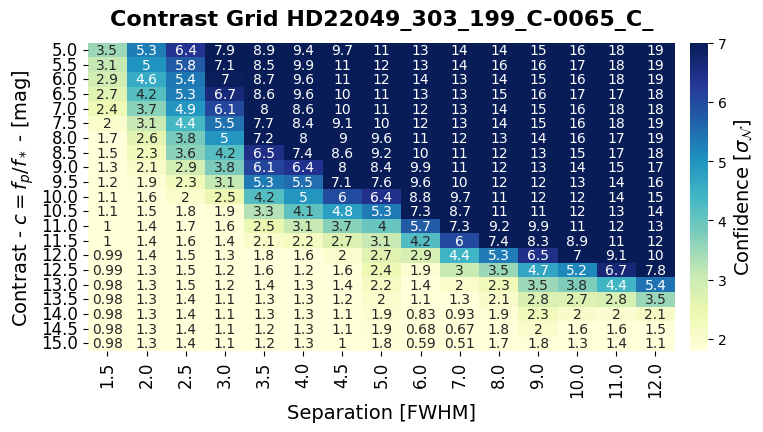

In [ ]:
fig = plt.figure(figsize=(8, 4))

gs0 = fig.add_gridspec(1, 1)
gs0.update(wspace=0.0, hspace=0.2)
gs1 = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec = gs0[0],
    wspace=0.05, width_ratios=[1, 0.03])

# All axis we need
contrast_ax = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs1[1])

# Plot the contrast grid
plot_contrast_grid(
    contrast_grid_axis=contrast_ax,
    colorbar_axis=colorbar_ax,
    contrast_grid=over_all_best)

colorbar_ax.yaxis.label.set_size(14)

contrast_ax.set_ylabel(
    "Contrast - $c = f_p / f_*$ - [mag]", size=14)
contrast_ax.set_xlabel(
    r"Separation [FWHM]", size=14)
contrast_ax.set_title(
    "Contrast Grid " + dataset_name,
    fontsize=16,
    fontweight="bold",
    y=1.03)

contrast_ax.tick_params(
    axis='both',
    which='major',
    labelsize=12)

# Save the figure
fig.patch.set_facecolor('white')
plt.savefig("contrast_grid_pca_best_off_" + dataset_name + ".pdf", bbox_inches='tight')

In [29]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
lookup_table = deepcopy(contrast_instance.contrast_results["pca_stacked_05_PCA_002_components"].idx_table)
lookup_table.columns = flux_ratio2mag(lookup_table.columns)
lookup_table.index = lookup_table.index / 3.6
lookup_table 

flux_ratio,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,10.5,11.0,11.5,12.0,12.5,13.0,13.5,14.0,14.5,15.0
separation,,,,,,,,,,,,,,,,,,,,,
1.5,1,16,31,46,61,76,91,106,121,136,151,166,181,196,211,226,241,256,271,286,301
2.0,2,17,32,47,62,77,92,107,122,137,152,167,182,197,212,227,242,257,272,287,302
2.5,3,18,33,48,63,78,93,108,123,138,153,168,183,198,213,228,243,258,273,288,303
3.0,4,19,34,49,64,79,94,109,124,139,154,169,184,199,214,229,244,259,274,289,304
3.5,5,20,35,50,65,80,95,110,125,140,155,170,185,200,215,230,245,260,275,290,305
4.0,6,21,36,51,66,81,96,111,126,141,156,171,186,201,216,231,246,261,276,291,306
4.5,7,22,37,52,67,82,97,112,127,142,157,172,187,202,217,232,247,262,277,292,307
5.0,8,23,38,53,68,83,98,113,128,143,158,173,188,203,218,233,248,263,278,293,308
6.0,9,24,39,54,69,84,99,114,129,144,159,174,189,204,219,234,249,264,279,294,309


# Find the setups at the edge to run them with S4

In [30]:
distance_from_5_2 = (over_all_best - 5.2).abs().values
distance_from_1_8 = (over_all_best - 1.8).abs().values

In [31]:
minima_upper = np.argmin(distance_from_5_2, axis=0)
minima_lower = np.argmin(distance_from_1_8, axis=0)

In [32]:
upper = lookup_table.columns[minima_upper].values
lower = lookup_table.columns[minima_lower].values
lower[7] = 12. # some values are off

In [34]:
use_rotation_loss = "1"
num_epochs = 500
lambda_reg = 809.64

In [35]:
selection_file = experiment_root_dir.parent / Path("xx_S4_" + dataset_name + ".txt")

In [36]:
don_t_use = []
with open(selection_file, "w") as text_file:
    text_file.write(dataset_name + " " + "0000 1 " + str(num_epochs) + " " + str(lambda_reg)+ "\n")
    for idx_sep, tmp_separation in enumerate(lookup_table.index):
        for tmp_flux_ratio in lookup_table.columns:
            current_idx = lookup_table[float(tmp_flux_ratio)][tmp_separation]

            if (tmp_flux_ratio <= lower[idx_sep]) & (tmp_flux_ratio >= upper[idx_sep]):
                print(str(current_idx).zfill(4))
                
                
                text_file.write(dataset_name + " " + str(current_idx).zfill(4) + "a 1 " + str(num_epochs) + " " + str(lambda_reg)+ "\n")
                text_file.write(dataset_name + " " + str(current_idx).zfill(4) + "b 1 " + str(num_epochs) + " " + str(lambda_reg)+ "\n")
                text_file.write(dataset_name + " " + str(current_idx).zfill(4) + "c 1 " + str(num_epochs) + " " + str(lambda_reg)+ "\n")
                
            else:
                don_t_use.append(str(current_idx).zfill(4) + "a")
                don_t_use.append(str(current_idx).zfill(4) + "b")
                don_t_use.append(str(current_idx).zfill(4) + "c")

0001
0016
0031
0046
0061
0076
0091
0002
0017
0032
0047
0062
0077
0092
0107
0122
0137
0048
0063
0078
0093
0108
0123
0138
0153
0168
0094
0109
0124
0139
0154
0169
0140
0155
0170
0185
0200
0215
0156
0171
0186
0201
0216
0172
0187
0202
0217
0173
0188
0203
0218
0189
0204
0219
0234
0220
0235
0250
0221
0236
0251
0266
0281
0296
0237
0252
0267
0282
0297
0312
0238
0253
0268
0283
0298
0254
0269
0284
0299
0255
0270
0285


# Create empty residuals for the files we don't compute

In [37]:
dummy_image = np.ones_like(science_data[0])

In [38]:
method_names = ["s4_mean_S4_rotation_loss", "s4_median_S4_rotation_loss"]

In [42]:
for tmp_method_name in method_names:
    print(tmp_method_name)
    
    for tmp_exp_id in don_t_use:
        tmp_file = experiment_root_dir / Path("residuals") \
            / Path(tmp_method_name) / Path("residual_ID_" + tmp_exp_id + ".fits")
        
        print(tmp_file)
        if not tmp_file.is_file():            
            save_as_fits(dummy_image, str(tmp_file))

s4_mean_S4_rotation_loss
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0106a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0106b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0106c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0121a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0121b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0121c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0136a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/r

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0003b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0003c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0018a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0018b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0018c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0033a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0033b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotat

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0304b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0304c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0005a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0005b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0005c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0020a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0020b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotat

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0231b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0231c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0246a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0246b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0246c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0261a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0261b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotat

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0068a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0068b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0068c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0083a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0083b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0083c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0098a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotat

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0264c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0279a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0279b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0279c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0294a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0294b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0294c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotat

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0071c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0086a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0086b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0086c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0101a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0101b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0101c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotat

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0013c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0028a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0028b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0028c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0043a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0043b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0043c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotat

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0179a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0179b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0179c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0194a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0194b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0194c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotation_loss/residual_ID_0209a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_mean_S4_rotat

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0136a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0136b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0136c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0151a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0151b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0151c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0166a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0033c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0183a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0183b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0183c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0198a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0198b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0198c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0304c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0005a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0005b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0005c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0020a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0020b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0020c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0231b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0231c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0246a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0246b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0246c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0261a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0261b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0038b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0038c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0053a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0053b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0053c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0068a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0068b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0159a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0159b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0159c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0174a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0174b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0174c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0249a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0310a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0310b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0310c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0011a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0011b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0011c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0026a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0147a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0147b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0147c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0162a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0162b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0162c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0177a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0059c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0074a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0074b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0074c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0089a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0089b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0089c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4

/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0195a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0195b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0195c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0210a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0210b.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0210c.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4_median_S4_rotation_loss/residual_ID_0225a.fits
/fast/mbonse/s4/70_results/10_contrast_grids/HD22049_303_199_C-0065_C_/residuals/s4